In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np


In [4]:
# Carrega o dataset completo com preços, geração, load, e clima
df = pd.read_csv("dataset.csv", parse_dates=['time'])
df.set_index('time', inplace=True)

# Verifica se a coluna de preço está presente
print(df.columns[df.columns.str.contains("price", case=False)])

Index(['price day ahead', 'price actual'], dtype='object')


In [5]:
def add_lag_and_time_features(df):
    df = df.copy()
    df['lag_1h'] = df['price actual'].shift(1)
    df['lag_24h'] = df['price actual'].shift(24)
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df.dropna()

df_prepared = add_lag_and_time_features(df)


In [6]:
def create_custom_sliding_windows(df):
    """
    Cria janelas fixas com:
    - Janela 1: treino 2015, teste 2016
    - Janela 2: treino 2016, teste 2017
    - Janela 3-A: treino 2016–2017, teste 2018
    - Janela 3-B: treino 2015–2017, teste 2018
    """
    df = df.copy()
    df = df.sort_index()

    splits = []

    configs = [
        ('2015-01-01', '2015-12-31', '2016-01-01', '2016-12-31'),  # Janela 1
        ('2016-01-01', '2016-12-31', '2017-01-01', '2017-12-31'),  # Janela 2
        ('2016-01-01', '2017-12-31', '2018-01-01', '2018-12-31'),  # Janela 3-A
        ('2015-01-01', '2017-12-31', '2018-01-01', '2018-12-31')   # Janela 3-B
    ]

    for train_start, train_end, test_start, test_end in configs:
        df_train = df.loc[train_start:train_end]
        df_test = df.loc[test_start:test_end]
        splits.append((df_train, df_test))

    return splits

# Criar os splits
splits = create_custom_sliding_windows(df_prepared)

# Visualizar os períodos
for i, (train, test) in enumerate(splits, start=1):
    print(f"Janela {i}:")
    print(f"  Treino: {train.index.min().date()} → {train.index.max().date()}  ({len(train)} registos)")
    print(f"  Teste:  {test.index.min().date()} → {test.index.max().date()}  ({len(test)} registos)\n")


Janela 1:
  Treino: 2015-01-01 → 2015-12-31  (8737 registos)
  Teste:  2016-01-01 → 2016-12-31  (8784 registos)

Janela 2:
  Treino: 2016-01-01 → 2016-12-31  (8784 registos)
  Teste:  2017-01-01 → 2017-12-31  (8760 registos)

Janela 3:
  Treino: 2016-01-01 → 2017-12-31  (17544 registos)
  Teste:  2018-01-01 → 2018-12-31  (8759 registos)

Janela 4:
  Treino: 2015-01-01 → 2017-12-31  (26281 registos)
  Teste:  2018-01-01 → 2018-12-31  (8759 registos)



In [7]:
forecast_horizon = 24  # ou 168 para longo prazo
df_prepared['target'] = df_prepared['price actual'].shift(-forecast_horizon)
df_prepared = df_prepared.dropna(subset=['target'])

In [ ]:
def sliding_expanding_shortterm_lr(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    import numpy as np
    import pandas as pd

    df = df.copy()
    results = []

    # Converter todas as datas para timezone UTC
    train_start = pd.to_datetime(train_start).tz_localize("UTC")
    train_end = pd.to_datetime(train_end).tz_localize("UTC")
    current_test_start = pd.to_datetime(test_start).tz_localize("UTC")
    final_test_end = pd.to_datetime(test_end).tz_localize("UTC")

    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]
        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        X_test_scaled = scaler_X.transform(X_test)

        model = LinearRegression()
        model.fit(X_train_scaled, y_train_scaled)
        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'start_test': current_test_start,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        current_test_start += pd.Timedelta(days=1)

    return pd.DataFrame(results)


In [ ]:
df_results_default_lr_window1 = sliding_expanding_shortterm_lr(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print("Multi Linear Regression - Window 1")
print("MAE:", df_results_default_lr_window1['MAE'].mean())
print("RMSE:", df_results_default_lr_window1['RMSE'].mean())
print("MAPE (%):", df_results_default_lr_window1['MAPE (%)'].mean())
print("rMAE:", df_results_default_lr_window1['rMAE'].mean())

df_results_default_lr_window2 = sliding_expanding_shortterm_lr(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print("Multi Linear Regression - Window 2")
print("MAE:", df_results_default_lr_window2['MAE'].mean())
print("RMSE:", df_results_default_lr_window2['RMSE'].mean())
print("MAPE (%):", df_results_default_lr_window2['MAPE (%)'].mean())
print("rMAE:", df_results_default_lr_window2['rMAE'].mean())

df_results_default_lr_window3 = sliding_expanding_shortterm_lr(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("Multi Linear Regression - Window 3")
print("MAE:", df_results_default_lr_window3['MAE'].mean())
print("RMSE:", df_results_default_lr_window3['RMSE'].mean())
print("MAPE (%):", df_results_default_lr_window3['MAPE (%)'].mean())
print("rMAE:", df_results_default_lr_window3['rMAE'].mean())

df_results_default_lr_window4 = sliding_expanding_shortterm_lr(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("Multi Linear Regression - Window 4")
print("MAE:", df_results_default_lr_window4['MAE'].mean())
print("RMSE:", df_results_default_lr_window4['RMSE'].mean())
print("MAPE (%):", df_results_default_lr_window4['MAPE (%)'].mean())
print("rMAE:", df_results_default_lr_window4['rMAE'].mean())

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def sliding_expanding_shortterm_rf(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    df = df.copy()
    df.index = df.index.tz_localize(None)  # remover timezone
    df_results = []

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        df_results.append({
            'start': current_test_start,
            'end': current_test_end,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        # Expansão do treino
        current_test_start += pd.Timedelta(hours=forecast_horizon)

    return pd.DataFrame(df_results)


In [ ]:
df_results_default_rf_window1 = sliding_expanding_shortterm_rf(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print("Random Forest - Window 1")
print("MAE:", df_results_default_rf_window1['MAE'].mean())
print("RMSE:", df_results_default_rf_window1['RMSE'].mean())
print("MAPE (%):", df_results_default_rf_window1['MAPE (%)'].mean())
print("rMAE:", df_results_default_rf_window1['rMAE'].mean())

df_results_default_rf_window2 = sliding_expanding_shortterm_rf(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print("Random Forest - Window 2")
print("MAE:", df_results_default_rf_window2['MAE'].mean())
print("RMSE:", df_results_default_rf_window2['RMSE'].mean())
print("MAPE (%):", df_results_default_rf_window2['MAPE (%)'].mean())
print("rMAE:", df_results_default_rf_window2['rMAE'].mean())

df_results_default_rf_window3 = sliding_expanding_shortterm_rf(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("Random Forest - Window 3")
print("MAE:", df_results_default_rf_window3['MAE'].mean())
print("RMSE:", df_results_default_rf_window3['RMSE'].mean())
print("MAPE (%):", df_results_default_rf_window3['MAPE (%)'].mean())
print("rMAE:", df_results_default_rf_window3['rMAE'].mean())

df_results_default_rf_window4 = sliding_expanding_shortterm_rf(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("Random Forest - Window 4")
print("MAE:", df_results_default_rf_window4['MAE'].mean())
print("RMSE:", df_results_default_rf_window4['RMSE'].mean())
print("MAPE (%):", df_results_default_rf_window4['MAPE (%)'].mean())
print("rMAE:", df_results_default_rf_window4['rMAE'].mean())

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

def sliding_expanding_shortterm_xgb(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    results = []

    df = df.copy()
    df = df.tz_localize(None)  # garantir que não há timezone
    df = df.sort_index()

    current_test_start = pd.Timestamp(test_start)
    final_test_end = pd.Timestamp(test_end)

    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        drop_cols = ['price actual', 'price day ahead']
        feature_cols = [col for col in df_train.columns if col not in drop_cols]

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
        model.fit(X_train_scaled, y_train_scaled)

        y_pred_scaled = model.predict(X_test_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        rmae = mae / np.mean(np.abs(y_test))

        results.append({
            'timestamp': current_test_start,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

        # expandir janela de treino
        current_test_start += pd.Timedelta(hours=forecast_horizon)

    return pd.DataFrame(results)


In [ ]:
df_results_default_xgboost_window1 = sliding_expanding_shortterm_xgb(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print("XGBoost - Window 1")
print("MAE:", df_results_default_xgboost_window1['MAE'].mean())
print("RMSE:", df_results_default_xgboost_window1['RMSE'].mean())
print("MAPE (%):", df_results_default_xgboost_window1['MAPE (%)'].mean())
print("rMAE:", df_results_default_xgboost_window1['rMAE'].mean())

df_results_default_xgboost_window2 = sliding_expanding_shortterm_xgb(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print("XGBoost - Window 2")
print("MAE:", df_results_default_xgboost_window2['MAE'].mean())
print("RMSE:", df_results_default_xgboost_window2['RMSE'].mean())
print("MAPE (%):", df_results_default_xgboost_window2['MAPE (%)'].mean())
print("rMAE:", df_results_default_xgboost_window2['rMAE'].mean())

df_results_default_xgboost_window3 = sliding_expanding_shortterm_xgb(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("XGBoost - Window 3")
print("MAE:", df_results_default_xgboost_window3['MAE'].mean())
print("RMSE:", df_results_default_xgboost_window3['RMSE'].mean())
print("MAPE (%):", df_results_default_xgboost_window3['MAPE (%)'].mean())
print("rMAE:", df_results_default_xgboost_window3['rMAE'].mean())

df_results_default_xgboost_window4 = sliding_expanding_shortterm_xgb(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("XGBoost - Window 4")
print("MAE:", df_results_default_xgboost_window4['MAE'].mean())
print("RMSE:", df_results_default_xgboost_window4['RMSE'].mean())
print("MAPE (%):", df_results_default_xgboost_window4['MAPE (%)'].mean())
print("rMAE:", df_results_default_xgboost_window4['rMAE'].mean())

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def sliding_expanding_shortterm_rnn_fast(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    feature_cols = [col for col in df.columns if col not in ['price actual', 'price day ahead']]
    all_y_true = []
    all_y_pred = []

    test_length = (final_test_end - current_test_start).days + 1
    steps = test_length
    checkpoints = {int(steps * 0.25): "25%", int(steps * 0.5): "50%", int(steps * 0.75): "75%"}

    for step in range(steps):
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_start = pd.to_datetime(test_start) + pd.Timedelta(days=step)
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        if current_test_end > final_test_end:
            break

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        if len(df_test) < forecast_horizon:
            continue

        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
        X_test_scaled = scaler_X.transform(X_test)

        def build_sequences(X, y, timesteps=24):
            Xs, ys = [], []
            for i in range(timesteps, len(X)):
                Xs.append(X[i - timesteps:i])
                ys.append(y[i])
            return np.array(Xs), np.array(ys)

        X_train_seq, y_train_seq = build_sequences(X_train_scaled, y_train_scaled, timesteps=24)

        if len(X_train_seq) == 0:
            continue

        model = Sequential()
        model.add(SimpleRNN(50, activation='relu', input_shape=(24, X_train_seq.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

        X_input = X_test_scaled[:24].reshape((1, 24, X_test_scaled.shape[1]))
        y_pred_scaled = model.predict(X_input).ravel()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        all_y_true.append(y_test[0])
        all_y_pred.append(y_pred[0])

    # Calcular métricas globais
    if len(all_y_true) > 0:
        mae = mean_absolute_error(all_y_true, all_y_pred)
        rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
        mape = mean_absolute_percentage_error(all_y_true, all_y_pred) * 100
        rmae = mae / np.mean(np.abs(all_y_true))

        return pd.DataFrame([{
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        }])
    else:
        print("⚠️ Não foram feitas previsões suficientes.")
        return pd.DataFrame()


In [ ]:
df_results_default_rnn_window1 = sliding_expanding_shortterm_rnn_fast(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print(df_results_default_rnn_window1.head())
print(df_results_default_rnn_window1.columns)
print(df_results_default_rnn_window1.shape)

print("Recursive Neural Networks - Window 1")
print("MAE:", df_results_default_rnn_window1['MAE'].mean())
print("RMSE:", df_results_default_rnn_window1['RMSE'].mean())
print("MAPE (%):", df_results_default_rnn_window1['MAPE (%)'].mean())
print("rMAE:", df_results_default_rnn_window1['rMAE'].mean())

df_results_default_rnn_window2 = sliding_expanding_shortterm_rnn_fast(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print("Recursive Neural Networks - Window 2")
print("MAE:", df_results_default_rnn_window2['MAE'].mean())
print("RMSE:", df_results_default_rnn_window2['RMSE'].mean())
print("MAPE (%):", df_results_default_rnn_window2['MAPE (%)'].mean())
print("rMAE:", df_results_default_rnn_window2['rMAE'].mean())

df_results_default_rnn_window3 = sliding_expanding_shortterm_rnn_fast(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("Recursive Neural Networks - Window 3")
print("MAE:", df_results_default_rnn_window3['MAE'].mean())
print("RMSE:", df_results_default_rnn_window3['RMSE'].mean())
print("MAPE (%):", df_results_default_rnn_window3['MAPE (%)'].mean())
print("rMAE:", df_results_default_rnn_window3['rMAE'].mean())

df_results_default_rnn_window4 = sliding_expanding_shortterm_rnn_fast(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("Recursive Neural Networks - Window 4")
print("MAE:", df_results_default_rnn_window4['MAE'].mean())
print("RMSE:", df_results_default_rnn_window4['RMSE'].mean())
print("MAPE (%):", df_results_default_rnn_window4['MAPE (%)'].mean())
print("rMAE:", df_results_default_rnn_window4['rMAE'].mean())

In [84]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

def sliding_expanding_shortterm_arima_glm(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    feature_cols = [col for col in df.columns if col not in ['price actual', 'price day ahead']]
    all_y_true = []
    all_y_pred = []

    steps = (final_test_end - current_test_start).days + 1
    checkpoints = {int(steps * 0.25): "25%", int(steps * 0.5): "50%", int(steps * 0.75): "75%"}

    for step in range(steps):
        if step in checkpoints:
            print(f"⏳ Progresso: {checkpoints[step]} da janela de teste")

        current_test_start = pd.to_datetime(test_start) + pd.Timedelta(days=step)
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

        if current_test_end > final_test_end:
            break

        df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
        df_test = df.loc[current_test_start:current_test_end]

        if len(df_test) < forecast_horizon:
            continue

        # ARIMA para capturar componente temporal (1,0,0) simples
        try:
            arima_model = ARIMA(df_train['price actual'], order=(1, 0, 0))
            arima_result = arima_model.fit()
            arima_forecast = arima_result.forecast(steps=1)[0]
        except:
            continue

        # GLM (Regressão) com features
        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].values
        X_test = df_test[feature_cols].values
        y_test = df_test['price actual'].values

        scaler_X = StandardScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        glm = LinearRegression()
        glm.fit(X_train_scaled, y_train)
        glm_forecast = glm.predict(X_test_scaled[:1])[0]

        # Combinação: média simples entre ARIMA e GLM
        final_pred = (arima_forecast + glm_forecast) / 2

        all_y_true.append(y_test[0])
        all_y_pred.append(final_pred)

    # Métricas finais
    if len(all_y_true) > 0:
        mae = mean_absolute_error(all_y_true, all_y_pred)
        rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
        mape = mean_absolute_percentage_error(all_y_true, all_y_pred) * 100
        rmae = mae / np.mean(np.abs(all_y_true))

        return pd.DataFrame([{
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        }])
    else:
        print("⚠️ Não foram feitas previsões suficientes.")
        return pd.DataFrame()


In [85]:
df_results_default_arima_window1 = sliding_expanding_shortterm_arima_glm(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print("ARIMA-GLM - Window 1")
print("MAE:", df_results_default_arima_window1['MAE'].mean())
print("RMSE:", df_results_default_arima_window1['RMSE'].mean())
print("MAPE (%):", df_results_default_arima_window1['MAPE (%)'].mean())
print("rMAE:", df_results_default_arima_window1['rMAE'].mean())

df_results_default_arima_window2 = sliding_expanding_shortterm_arima_glm(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print("ARIMA-GLM - Window 2")
print("MAE:", df_results_default_arima_window2['MAE'].mean())
print("RMSE:", df_results_default_arima_window2['RMSE'].mean())
print("MAPE (%):", df_results_default_arima_window2['MAPE (%)'].mean())
print("rMAE:", df_results_default_arima_window2['rMAE'].mean())

df_results_default_arima_window3 = sliding_expanding_shortterm_arima_glm(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("ARIMA-GLM - Window 3")
print("MAE:", df_results_default_arima_window3['MAE'].mean())
print("RMSE:", df_results_default_arima_window3['RMSE'].mean())
print("MAPE (%):", df_results_default_arima_window3['MAPE (%)'].mean())
print("rMAE:", df_results_default_arima_window3['rMAE'].mean())

df_results_default_arima_window4 = sliding_expanding_shortterm_arima_glm(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("ARIMA-GLM - Window 4")
print("MAE:", df_results_default_arima_window4['MAE'].mean())
print("RMSE:", df_results_default_arima_window4['RMSE'].mean())
print("MAPE (%):", df_results_default_arima_window4['MAPE (%)'].mean())
print("rMAE:", df_results_default_arima_window4['rMAE'].mean())

⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
ARIMA-GLM - Window 1
MAE: 2.5657082551628063
RMSE: 3.2093564266008228
MAPE (%): 7.386800319628612
rMAE: 0.06258063375179838
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
ARIMA-GLM - Window 2
MAE: 2.6040829489232658
RMSE: 3.408231768622885
MAPE (%): 5.201915115709984
rMAE: 0.0494298042964282
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
ARIMA-GLM - Window 3
MAE: 2.547164754592803
RMSE: 3.70803220368238
MAPE (%): 5.708430393141137
rMAE: 0.04503491300640914
⏳ Progresso: 25% da janela de teste
⏳ Progresso: 50% da janela de teste
⏳ Progresso: 75% da janela de teste
ARIMA-GLM - Window 4
MAE: 2.616215970889564
RMSE: 3.766349899539134
MAPE (%): 5.838657162166578
rMAE: 0.04625576670788418


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def sliding_expanding_shortterm_lstm(df, train_start, train_end, test_start, test_end, forecast_horizon=24, units=100, epochs=10, batch_size=32):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    current_test_start = pd.to_datetime(test_start)
    final_test_end = pd.to_datetime(test_end)

    drop_cols = ['price actual', 'price day ahead']
    feature_cols = [col for col in df.columns if col not in drop_cols]

    df_train = df.loc[train_start:train_end]
    X_train = df_train[feature_cols].values
    y_train = df_train['price actual'].shift(-forecast_horizon).dropna().values
    X_train = X_train[:-forecast_horizon]  # alinhar X e y

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    def build_sequences(X, y, timesteps=24):
        Xs, ys = [], []
        for i in range(timesteps, len(X)):
            Xs.append(X[i - timesteps:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X_seq, y_seq = build_sequences(X_train_scaled, y_train_scaled, timesteps=24)

    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

    y_true_all = []
    y_pred_all = []

    while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
        current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
        df_test = df.loc[current_test_start:current_test_end]

        X_test = df_test[feature_cols].values
        X_test_scaled = scaler_X.transform(X_test)
        if len(X_test_scaled) < 24:
            break
        X_test_seq = X_test_scaled[:24].reshape((1, 24, X_test_scaled.shape[1]))

        y_pred_scaled = model.predict(X_test_seq).ravel()
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        y_true = df_test['price actual'].iloc[forecast_horizon - 1]

        y_pred_all.append(y_pred[-1])
        y_true_all.append(y_true)

        current_test_start += pd.Timedelta(hours=forecast_horizon)

    mae = mean_absolute_error(y_true_all, y_pred_all)
    rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
    mape = mean_absolute_percentage_error(y_true_all, y_pred_all) * 100
    rmae = mae / np.mean(np.abs(y_true_all))

    results = pd.DataFrame([{
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'rMAE': rmae
    }])
    return results


In [9]:
df_results_default_lstm_window1 = sliding_expanding_shortterm_lstm(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2015-12-31',
    test_start='2016-01-01',
    test_end='2016-12-31'
)

print("LSTM - Window 1")
print("MAE:", df_results_default_lstm_window1['MAE'].mean())
print("RMSE:", df_results_default_lstm_window1['RMSE'].mean())
print("MAPE (%):", df_results_default_lstm_window1['MAPE (%)'].mean())
print("rMAE:", df_results_default_lstm_window1['rMAE'].mean())

df_results_default_lstm_window2 = sliding_expanding_shortterm_lstm(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print("LSTM - Window 2")
print("MAE:", df_results_default_lstm_window2['MAE'].mean())
print("RMSE:", df_results_default_lstm_window2['RMSE'].mean())
print("MAPE (%):", df_results_default_lstm_window2['MAPE (%)'].mean())
print("rMAE:", df_results_default_lstm_window2['rMAE'].mean())

df_results_default_lstm_window3 = sliding_expanding_shortterm_lstm(
    df=df_prepared,
    train_start='2016-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("LSTM - Window 3")
print("MAE:", df_results_default_lstm_window3['MAE'].mean())
print("RMSE:", df_results_default_lstm_window3['RMSE'].mean())
print("MAPE (%):", df_results_default_lstm_window3['MAPE (%)'].mean())
print("rMAE:", df_results_default_lstm_window3['rMAE'].mean())

df_results_default_lstm_window4 = sliding_expanding_shortterm_lstm(
    df=df_prepared,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print("LSTM - Window 4")
print("MAE:", df_results_default_lstm_window4['MAE'].mean())
print("RMSE:", df_results_default_lstm_window4['RMSE'].mean())
print("MAPE (%):", df_results_default_lstm_window4['MAPE (%)'].mean())
print("rMAE:", df_results_default_lstm_window4['rMAE'].mean())

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

# Tunning XGBoost

In [10]:
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

def sliding_expanding_shortterm_xgb_tuning(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1]
    }

    results_summary = []

    for n_estimators, max_depth, learning_rate in product(param_grid['n_estimators'],
                                                          param_grid['max_depth'],
                                                          param_grid['learning_rate']):
        print(f"Testing config: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}")

        df_local = df.copy()
        df_local = df_local.tz_localize(None)
        df_local = df_local.sort_index()

        current_test_start = pd.Timestamp(test_start)
        final_test_end = pd.Timestamp(test_end)

        metric_list = []

        while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
            current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

            df_train = df_local.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
            df_test = df_local.loc[current_test_start:current_test_end]

            drop_cols = ['price actual', 'price day ahead']
            feature_cols = [col for col in df_train.columns if col not in drop_cols]

            X_train = df_train[feature_cols].values
            y_train = df_train['price actual'].values
            X_test = df_test[feature_cols].values
            y_test = df_test['price actual'].values

            scaler_X = StandardScaler()
            scaler_y = StandardScaler()

            X_train_scaled = scaler_X.fit_transform(X_train)
            X_test_scaled = scaler_X.transform(X_test)
            y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

            model = XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                random_state=42,
                verbosity=0
            )
            model.fit(X_train_scaled, y_train_scaled)

            y_pred_scaled = model.predict(X_test_scaled)
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = mean_absolute_percentage_error(y_test, y_pred) * 100
            rmae = mae / np.mean(np.abs(y_test))

            metric_list.append([mae, rmse, mape, rmae])
            current_test_start += pd.Timedelta(hours=forecast_horizon)

        metric_array = np.array(metric_list)
        results_summary.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'MAE_mean': metric_array[:, 0].mean(),
            'RMSE_mean': metric_array[:, 1].mean(),
            'MAPE_mean': metric_array[:, 2].mean(),
            'rMAE_mean': metric_array[:, 3].mean()
        })

    return pd.DataFrame(results_summary).sort_values(by='MAPE_mean')


In [11]:
results_xgb_tunning_short_term = sliding_expanding_shortterm_xgb_tuning(df, '2016-01-01', '2016-12-31', '2017-01-01', '2017-12-31')
print(results_xgb_tunning_short_term)

Testing config: n_estimators=100, max_depth=4, learning_rate=0.01
Testing config: n_estimators=100, max_depth=4, learning_rate=0.05
Testing config: n_estimators=100, max_depth=4, learning_rate=0.1
Testing config: n_estimators=100, max_depth=6, learning_rate=0.01
Testing config: n_estimators=100, max_depth=6, learning_rate=0.05
Testing config: n_estimators=100, max_depth=6, learning_rate=0.1
Testing config: n_estimators=100, max_depth=8, learning_rate=0.01
Testing config: n_estimators=100, max_depth=8, learning_rate=0.05
Testing config: n_estimators=100, max_depth=8, learning_rate=0.1
Testing config: n_estimators=200, max_depth=4, learning_rate=0.01
Testing config: n_estimators=200, max_depth=4, learning_rate=0.05
Testing config: n_estimators=200, max_depth=4, learning_rate=0.1
Testing config: n_estimators=200, max_depth=6, learning_rate=0.01
Testing config: n_estimators=200, max_depth=6, learning_rate=0.05
Testing config: n_estimators=200, max_depth=6, learning_rate=0.1
Testing config:

In [17]:
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def run_rf_grid_search(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    results_summary = []

    df = df.copy()
    df.index = df.index.tz_localize(None)
    df = df.sort_index()

    for n_estimators, max_depth, min_samples_split, min_samples_leaf in product(
            param_grid['n_estimators'],
            param_grid['max_depth'],
            param_grid['min_samples_split'],
            param_grid['min_samples_leaf']):

        print(f"Testing: n_estimators={n_estimators}, max_depth={max_depth}, "
              f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")

        current_test_start = pd.Timestamp(test_start)
        final_test_end = pd.Timestamp(test_end)
        metric_list = []

        while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
            current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

            df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
            df_test = df.loc[current_test_start:current_test_end]

            drop_cols = ['price actual', 'price day ahead']
            feature_cols = [col for col in df_train.columns if col not in drop_cols]

            X_train = df_train[feature_cols].values
            y_train = df_train['price actual'].values
            X_test = df_test[feature_cols].values
            y_test = df_test['price actual'].values

            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            X_train_scaled = scaler_X.fit_transform(X_train)
            X_test_scaled = scaler_X.transform(X_test)
            y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train_scaled, y_train_scaled)

            y_pred_scaled = model.predict(X_test_scaled)
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = mean_absolute_percentage_error(y_test, y_pred) * 100
            rmae = mae / np.mean(np.abs(y_test))

            metric_list.append([mae, rmse, mape, rmae])
            current_test_start += pd.Timedelta(hours=forecast_horizon)

        metric_array = np.array(metric_list)
        results_summary.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'MAE_mean': metric_array[:, 0].mean(),
            'RMSE_mean': metric_array[:, 1].mean(),
            'MAPE_mean': metric_array[:, 2].mean(),
            'rMAE_mean': metric_array[:, 3].mean()
        })

    return pd.DataFrame(results_summary).sort_values(by='MAPE_mean')

In [ ]:
results_rf_tunning = run_rf_grid_search(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(results_rf_tunning.head(10)) 

Testing: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1
Testing: n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2


KeyboardInterrupt: 

In [19]:
from itertools import product
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

def run_lstm_grid_search(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    param_grid = {
        'units': [50, 100],
        'batch_size': [16, 32],
        'epochs': [10, 20]
    }

    results = []

    drop_cols = ['price actual', 'price day ahead']
    feature_cols = [col for col in df.columns if col not in drop_cols]
    df = df.copy()
    df.index = df.index.tz_localize(None)

    for units, batch_size, epochs in product(param_grid['units'], param_grid['batch_size'], param_grid['epochs']):
        print(f"Training: units={units}, batch_size={batch_size}, epochs={epochs}")

        current_test_start = pd.to_datetime(test_start)
        final_test_end = pd.to_datetime(test_end)

        df_train = df.loc[train_start:train_end]
        X_train = df_train[feature_cols].values
        y_train = df_train['price actual'].shift(-forecast_horizon).dropna().values
        X_train = X_train[:-forecast_horizon]

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        def build_sequences(X, y, timesteps=24):
            Xs, ys = [], []
            for i in range(timesteps, len(X)):
                Xs.append(X[i - timesteps:i])
                ys.append(y[i])
            return np.array(Xs), np.array(ys)

        X_seq, y_seq = build_sequences(X_train_scaled, y_train_scaled)

        model = Sequential()
        model.add(LSTM(units, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_seq, y_seq, epochs=epochs, batch_size=batch_size, verbose=0)

        y_true_all = []
        y_pred_all = []

        while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
            current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)
            df_test = df.loc[current_test_start:current_test_end]

            X_test = df_test[feature_cols].values
            X_test_scaled = scaler_X.transform(X_test)
            if len(X_test_scaled) < 24:
                break
            X_test_seq = X_test_scaled[:24].reshape((1, 24, X_test_scaled.shape[1]))

            y_pred_scaled = model.predict(X_test_seq).ravel()
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
            y_true = df_test['price actual'].iloc[forecast_horizon - 1]

            y_pred_all.append(y_pred[-1])
            y_true_all.append(y_true)
            current_test_start += pd.Timedelta(hours=forecast_horizon)

        mae = mean_absolute_error(y_true_all, y_pred_all)
        rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
        mape = mean_absolute_percentage_error(y_true_all, y_pred_all) * 100
        rmae = mae / np.mean(np.abs(y_true_all))

        results.append({
            'units': units,
            'batch_size': batch_size,
            'epochs': epochs,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'rMAE': rmae
        })

    return pd.DataFrame(results).sort_values(by='MAPE (%)')


In [20]:
lstm_results_tunning = run_lstm_grid_search(
    df,
    train_start='2015-01-01',
    train_end='2017-12-31',
    test_start='2018-01-01',
    test_end='2018-12-31'
)

print(lstm_results_tunning.head(10))


Training: units=50, batch_size=16, epochs=10


C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

C:\Users\gpere\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from itertools import product

def run_arima_glm_grid_search(df, train_start, train_end, test_start, test_end, forecast_horizon=24):
    param_grid = list(product([0, 1, 2], repeat=3))  # (p, d, q)
    feature_cols = [col for col in df.columns if col not in ['price actual', 'price day ahead']]
    results = []

    df = df.copy()
    df.index = df.index.tz_localize(None)

    for p, d, q in param_grid:
        print(f"Testing ARIMA({p},{d},{q})")

        current_test_start = pd.to_datetime(test_start)
        final_test_end = pd.to_datetime(test_end)

        all_y_true = []
        all_y_pred = []

        while current_test_start + pd.Timedelta(hours=forecast_horizon - 1) <= final_test_end:
            current_test_end = current_test_start + pd.Timedelta(hours=forecast_horizon - 1)

            df_train = df.loc[train_start:current_test_start - pd.Timedelta(hours=1)]
            df_test = df.loc[current_test_start:current_test_end]

            if len(df_test) < forecast_horizon or len(df_train) < forecast_horizon:
                current_test_start += pd.Timedelta(hours=forecast_horizon)
                continue

            try:
                arima_model = ARIMA(df_train['price actual'], order=(p, d, q))
                arima_result = arima_model.fit()
                arima_forecast = arima_result.forecast(steps=1)[0]
            except:
                current_test_start += pd.Timedelta(hours=forecast_horizon)
                continue

            X_train = df_train[feature_cols].values
            y_train = df_train['price actual'].values
            X_test = df_test[feature_cols].values
            y_test = df_test['price actual'].values

            scaler_X = StandardScaler()
            X_train_scaled = scaler_X.fit_transform(X_train)
            X_test_scaled = scaler_X.transform(X_test)

            glm = LinearRegression()
            glm.fit(X_train_scaled, y_train)
            glm_forecast = glm.predict(X_test_scaled[:1])[0]

            final_pred = (arima_forecast + glm_forecast) / 2

            all_y_true.append(y_test[0])
            all_y_pred.append(final_pred)
            current_test_start += pd.Timedelta(hours=forecast_horizon)

        if len(all_y_true) > 0:
            mae = mean_absolute_error(all_y_true, all_y_pred)
            rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
            mape = mean_absolute_percentage_error(all_y_true, all_y_pred) * 100
            rmae = mae / np.mean(np.abs(all_y_true))

            results.append({
                'p': p,
                'd': d,
                'q': q,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE (%)': mape,
                'rMAE': rmae
            })

    return pd.DataFrame(results).sort_values(by='MAPE (%)')


In [ ]:
results_arima_glm = run_arima_glm_grid_search(
    df,
    train_start='2016-01-01',
    train_end='2016-12-31',
    test_start='2017-01-01',
    test_end='2017-12-31'
)

print(results_arima_glm.head(10))


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def forecast_day_with_xgb(df, train_start='2016-01-01', train_end='2016-12-31', forecast_day='2017-01-01'):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    forecast_start = pd.to_datetime(forecast_day)
    forecast_end = forecast_start + pd.Timedelta(hours=23)

    df_train = df.loc[train_start:train_end]
    df_test = df.loc[forecast_start:forecast_end]

    drop_cols = ['price actual', 'price day ahead']
    feature_cols = [col for col in df_train.columns if col not in drop_cols]

    X_train = df_train[feature_cols].values
    y_train = df_train['price actual'].values
    X_test = df_test[feature_cols].values
    y_test = df_test['price actual'].values

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train_scaled, y_train_scaled)

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    rmae = mae / np.mean(np.abs(y_test))

    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(df_test.index, y_test, label='Actual')
    plt.plot(df_test.index, y_pred, label='Predicted', linestyle='--')
    plt.title('XGBoost – Forecast vs Actual (2017-01-01)')
    plt.xlabel('Hour')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'y_test': y_test,
        'y_pred': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'rMAE': rmae
    }


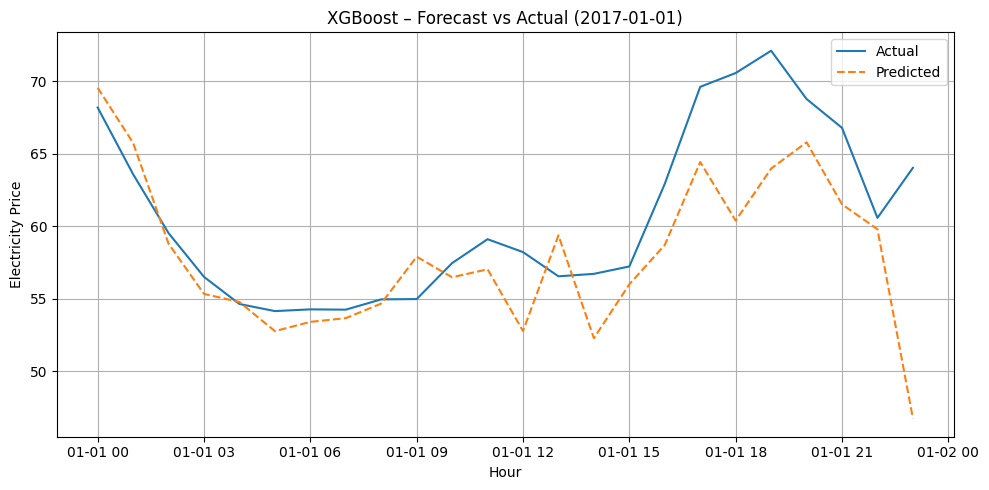

{'y_test': array([68.2 , 63.6 , 59.54, 56.52, 54.65, 54.16, 54.28, 54.26, 54.97,
       54.99, 57.47, 59.12, 58.23, 56.56, 56.73, 57.24, 62.94, 69.63,
       70.58, 72.12, 68.79, 66.8 , 60.59, 64.04]), 'y_pred': array([69.562706, 65.75978 , 58.80649 , 55.345837, 54.78814 , 52.777813,
       53.416462, 53.673878, 54.679577, 57.91354 , 56.492527, 57.044064,
       52.78791 , 59.379715, 52.29061 , 56.012623, 58.719193, 64.44171 ,
       60.40116 , 63.989777, 65.80504 , 61.5268  , 59.808918, 46.763645],
      dtype=float32), 'MAE': 3.4429102643330887, 'RMSE': np.float64(5.141243582370102), 'MAPE (%)': 5.412054700413416, 'rMAE': np.float64(0.05675087832088662)}


In [26]:
xgb_result_forecast24 = forecast_day_with_xgb(df)
print(xgb_result_forecast24)


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def forecast_day_with_rf(df, train_start='2016-01-01', train_end='2016-12-31', forecast_day='2017-01-01'):
    df = df.copy()
    df.index = df.index.tz_localize(None)

    forecast_start = pd.to_datetime(forecast_day)
    forecast_end = forecast_start + pd.Timedelta(hours=23)

    df_train = df.loc[train_start:train_end]
    df_test = df.loc[forecast_start:forecast_end]

    drop_cols = ['price actual', 'price day ahead']
    feature_cols = [col for col in df_train.columns if col not in drop_cols]

    X_train = df_train[feature_cols].values
    y_train = df_train['price actual'].values
    X_test = df_test[feature_cols].values
    y_test = df_test['price actual'].values

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_scaled, y_train_scaled)

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    rmae = mae / np.mean(np.abs(y_test))

    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(df_test.index, y_test, label='Actual')
    plt.plot(df_test.index, y_pred, label='Predicted', linestyle='--')
    plt.title('Random Forest – Forecast vs Actual (2017-01-01)')
    plt.xlabel('Hour')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'y_test': y_test,
        'y_pred': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'rMAE': rmae
    }


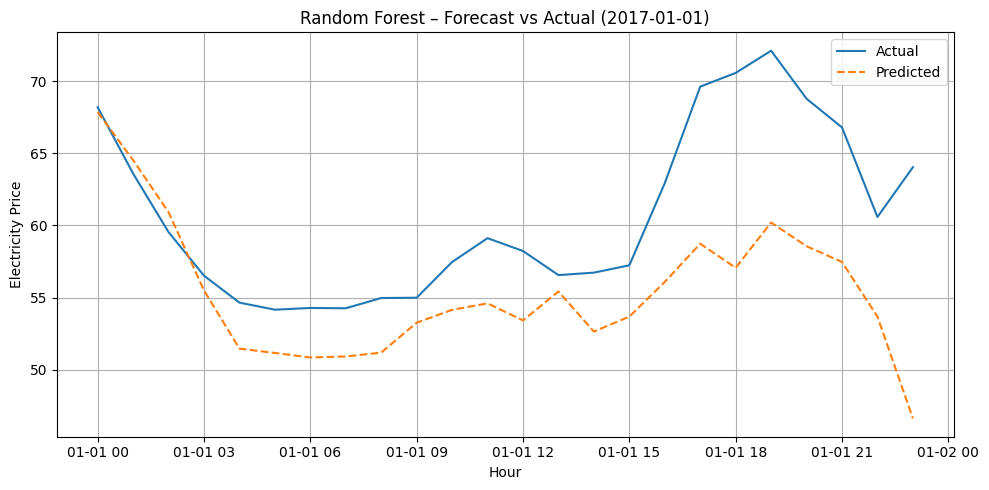

{'y_test': array([68.2 , 63.6 , 59.54, 56.52, 54.65, 54.16, 54.28, 54.26, 54.97,
       54.99, 57.47, 59.12, 58.23, 56.56, 56.73, 57.24, 62.94, 69.63,
       70.58, 72.12, 68.79, 66.8 , 60.59, 64.04]), 'y_pred': array([67.8611, 64.5371, 60.92  , 55.4961, 51.462 , 51.1594, 50.8481,
       50.9152, 51.1844, 53.2584, 54.1509, 54.5988, 53.4168, 55.4216,
       52.6435, 53.6825, 56.0837, 58.7352, 57.0668, 60.2048, 58.561 ,
       57.4689, 53.6743, 46.6262]), 'MAE': 5.444475, 'RMSE': np.float64(7.017052605557882), 'MAPE (%)': 8.615329253915844, 'rMAE': np.float64(0.08974347703655881)}


In [28]:
rf_result_forecast24 = forecast_day_with_rf(df)
print(rf_result_forecast24)


In [29]:
import numpy as np
from scipy.stats import t

def diebold_mariano_test(e1, e2, h=1, loss='abs'):
    """
    e1, e2: arrays de erros dos dois modelos (ex: y_true - y_pred)
    h: horizonte da previsão (1 para one-step-ahead)
    loss: 'abs' para MAE, 'squared' para MSE
    """
    e1 = np.array(e1)
    e2 = np.array(e2)

    if loss == 'squared':
        d = e1**2 - e2**2
    elif loss == 'abs':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("Loss must be 'abs' or 'squared'")

    mean_d = np.mean(d)
    n = len(d)
    var_d = np.var(d, ddof=1)

    dm_stat = mean_d / np.sqrt((var_d / n) + 2 * np.sum([
        (1 - k / h) * np.cov(d[:-k], d[k:])[0, 1] for k in range(1, h)
    ]) / n if h > 1 else (var_d / n))

    p_value = 2 * (1 - t.cdf(np.abs(dm_stat), df=n-1))
    return dm_stat, p_value


In [30]:
y_true = rf_result_forecast24['y_test']
xgb_pred = xgb_result_forecast24['y_pred']
rf_pred = rf_result_forecast24['y_pred']

e_xgb = y_true - xgb_pred
e_rf = y_true - rf_pred

dm_stat, p_val = diebold_mariano_test(e_xgb, e_rf, h=1, loss='abs')
print(f'DM Statistic: {dm_stat:.4f}, p-value: {p_val:.4f}')



DM Statistic: -3.9975, p-value: 0.0006
